Finetune BETO on classification task

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = 'cse493g1/project/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [2]:
!pip install transformers
!pip install datasets

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
import torch
import pandas as pd
import numpy as np

In [4]:
# use gpu
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
device

device(type='cuda')

In [5]:
df_train = pd.read_csv('/content/drive/MyDrive/cse493g1/project/beto/train_gender.csv')
df_val = pd.read_csv('/content/drive/MyDrive/cse493g1/project/beto/val_gender.csv')
df_test = pd.read_csv('/content/drive/MyDrive/cse493g1/project/beto/test_gender.csv')
gender_map = {'M': 0, 'F': 1}

In [6]:
df_train.head(5)

,Unnamed: 0,content,gender,rhyme,met
0,0,"Yo te he visto, en esa hora fugitiva\nen que l...",0,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['+++-++---+-', '---+---+-+-', '-+++-+---+-', ..."
1,1,"Cordula, ¿qué es posible haber quedado\nentre ...",0,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['-+-+-+-+-+-', '--+--+---+-', '-+---+-+-+-', ..."
2,2,Ese que en honra de la patria un día\nalzó tu ...,0,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['+--+---+++-', '-+-+---+-+-', '--+--+-+-+-', ..."
3,3,Cuando el sol de la tarde sus rayos amortigua\...,0,"['A', 'B', 'A', 'B', 'C', 'D', 'C', 'D', 'E', ...","['--+--+--+---+-', '-+-+-+--+---+-', '---+-+--..."
4,4,No temen las Piérides hermosas\nlas áureas fle...,0,"['A', 'B', 'B', 'A', 'A', 'B', 'B', 'A', 'C', ...","['++---+---+-', '-+-+---+-+-', '+--+---+--+-',..."


In [7]:
# get class weights, since we have an uneven distribution of labels
train_labs = df_train['gender'].tolist()
class_count = np.bincount(train_labs, minlength=len(gender_map))

# normalized inverse class weight
class_weights = torch.Tensor(len(train_labs) / (len(gender_map) * class_count)).to(device)

In [8]:
print(class_weights)

tensor([0.5367, 7.3158], device='cuda:0')


In [9]:
tokenizer = AutoTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

[646, 463, 391, 288, 283, 281, 276, 220, 211, 199, 193, 186, 184, 182, 177, 176, 176, 156, 146, 142, 137, 136, 135, 132, 132, 131, 131, 131, 130, 130, 129, 129, 129, 128, 128, 127, 127, 127, 126, 126, 126, 125, 125, 125, 125, 125, 124, 124, 124, 123, 123, 123, 123, 123, 123, 123, 122, 122, 122, 122, 122, 121, 121, 121, 121, 121, 121, 121, 121, 121, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 119, 119, 119, 119, 119, 119, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 117, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 116, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 114, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 113, 112, 112, 112, 112, 112, 112,

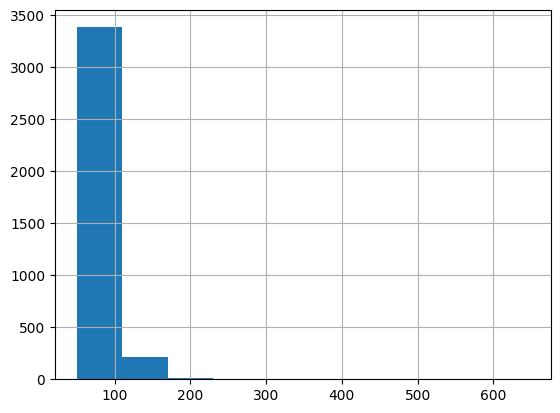

In [10]:
sequence_len = [len(c.split()) for c in df_train['content']]
sequence_len.sort(reverse=True)
pd.Series(sequence_len).hist(bins=10)
print(sequence_len)

In [11]:
# let's just set the max len to 256, nice power of 2, most of the data points are much below it
max_seq_len = 256

In [12]:
def tokenize(batch):
    return tokenizer(batch['content'], padding="max_length", truncation=True, max_length=max_seq_len)

df_train['labels'] = df_train['gender']
df_val['labels'] = df_val['gender']
df_test['labels'] = df_test['gender']
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
test_ds = Dataset.from_pandas(df_test)
# tokenize! both train and test
tokenized_train = train_ds.map(tokenize, batched=True)
tokenized_val = val_ds.map(tokenize, batched=True)
tokenized_test = test_ds.map(tokenize, batched=True)

Map:   0%|          | 0/3614 [00:00<?, ? examples/s]

Map:   0%|          | 0/401 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

In [13]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00


In [14]:
from beto_classifier import BETOClassifier
import evaluate
# eval beto model
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

In [15]:
def compute_metrics(pred):
    logits, labels = pred
    # logits -> class
    predictions = np.argmax(logits, axis=-1)
    acc = acc_metric.compute(predictions=predictions, references=labels)

    # Compute second metric (e.g., F1)
    f1_score = f1_metric.compute(predictions=predictions, references=labels, average="weighted")

    precision_score = precision_metric.compute(predictions=predictions, references=labels, average="weighted")

    recall_score = recall_metric.compute(predictions=predictions, references=labels, average="weighted")

    # Return both metrics together
    return {
        "accuracy": acc["accuracy"],
        "f1": f1_score["f1"],
        "precision": precision_score["precision"],
        "recall": recall_score["recall"]
    }

In [16]:
model = BETOClassifier(num_classes=2, class_weights=class_weights)
model.to(device)

# following https://huggingface.co/docs/transformers/en/training

training_args = TrainingArguments(
    output_dir="./gender_out",
    per_device_train_batch_size=32,
    num_train_epochs=5,
    eval_strategy="epoch",
    report_to=[] # don't want wand ai reporting
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.670437,0.912718,0.899626,0.889257,0.912718
2,No log,0.788727,0.551122,0.660201,0.870871,0.551122
3,No log,0.799039,0.735661,0.796627,0.883692,0.735661
4,No log,1.408479,0.915212,0.901153,0.890516,0.915212
5,0.493900,1.595048,0.922693,0.902668,0.890171,0.922693


TrainOutput(global_step=565, training_loss=0.45525343228230436, metrics={'train_runtime': 843.1357, 'train_samples_per_second': 21.432, 'train_steps_per_second': 0.67, 'total_flos': 0.0, 'train_loss': 0.45525343228230436, 'epoch': 5.0})

In [17]:
trainer.evaluate()

{'eval_loss': 1.5950480699539185,
 'eval_accuracy': 0.9226932668329177,
 'eval_f1': 0.9026675256355294,
 'eval_precision': 0.890171200497484,
 'eval_recall': 0.9226932668329177,
 'eval_runtime': 6.297,
 'eval_samples_per_second': 63.682,
 'eval_steps_per_second': 8.099,
 'epoch': 5.0}

In [18]:
pred_obj = trainer.predict(tokenized_test)
logits = pred_obj.predictions
pred_obj


PredictionOutput(predictions=array([[ 2.8416586 , -2.7887597 ],
       [ 2.7565994 , -2.7580593 ],
       [ 3.001844  , -2.9171295 ],
       [ 2.9772565 , -2.9382143 ],
       [ 2.3477695 , -2.300862  ],
       [ 2.9276695 , -2.9809072 ],
       [ 2.478941  , -2.5447109 ],
       [ 2.9705017 , -2.8029482 ],
       [-1.9476349 ,  1.8529837 ],
       [ 2.4723265 , -2.282274  ],
       [ 1.9322222 , -1.9436575 ],
       [ 2.5524962 , -2.514068  ],
       [ 2.9368098 , -2.8832045 ],
       [ 2.9340725 , -2.9382744 ],
       [ 2.8902864 , -2.779018  ],
       [ 2.4169035 , -2.4143536 ],
       [ 3.0602715 , -2.9853346 ],
       [ 1.471632  , -1.5284021 ],
       [ 2.9480743 , -2.9484704 ],
       [ 2.2941957 , -2.2069843 ],
       [ 2.9513788 , -2.901637  ],
       [ 3.0798757 , -2.989855  ],
       [ 2.9959044 , -2.9838114 ],
       [ 2.8474271 , -2.6443894 ],
       [ 3.0591092 , -3.0077615 ],
       [ 2.5634072 , -2.5779414 ],
       [ 2.8147528 , -2.8682516 ],
       [ 2.9923005 , -2.93

Make a plot!

In [19]:
import matplotlib.pyplot as plt

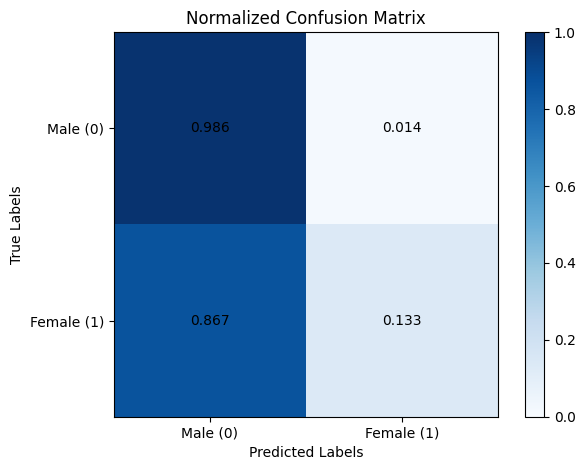

In [20]:
# visualize the splits for errors
actuals = np.argmax(logits, axis=-1)
expecteds = df_test['labels'].tolist()

# Initialize confusion matrix: [actual][predicted]
mtrx = [[0, 0],
      [0, 0]]

for actual, expected in zip(actuals, expecteds):

    mtrx[int(expected)][int(actual)] += 1

mtrx = np.array(mtrx)

# Normalize each row (i.e., per actual class)
mtrx_normal = (1.0* mtrx) / mtrx.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
im = ax.imshow(mtrx_normal, cmap='Blues', vmin=0, vmax=1)

# Labels, title and ticks
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Normalized Confusion Matrix')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Male (0)', 'Female (1)'])
ax.set_yticklabels(['Male (0)', 'Female (1)'])
for i in range(2):
    for j in range(2):
        value = mtrx_normal[i, j]
        ax.text(j, i, f'{value:.3f}', ha='center', va='center', color='black')

plt.colorbar(im)
plt.tight_layout()
plt.show()

In [21]:
trainer.save_model("./gender_finetuned")

Try to save model outputs

In [23]:
import shutil
from google.colab import files

shutil.make_archive('gender_finetuned', 'zip', '.', './gender_finetuned')
#shutil.make_archive('gender_out', 'zip', '.', './gender_out')

#files.download('gender_out.zip') # 2gb file :)

'/content/gender_finetuned.zip'